<a href="https://colab.research.google.com/github/malathisathish/Multiclass-fish-image-classification/blob/main/Multiclass_fish_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Fish Image Classification

In [ ]:
# Install required libraries
!pip install tensorflow keras streamlit opencv-python-headless

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import zipfile
from google.colab import drive, files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 139.0 MB/s eta 0:00:00


## Data extraction

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set ZIP path
zip_path = '/content/drive/MyDrive/Copy of Dataset.zip'

# Verify ZIP file exists
if not os.path.exists(zip_path):
    print("ZIP not found in Drive. Please upload the dataset ZIP.")
    uploaded = files.upload()
    zip_path = list(uploaded.keys())[0]

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.testzip()
except zipfile.BadZipFile:
    raise zipfile.BadZipFile(f"File at {zip_path} is not a valid ZIP. Redownload or verify.")

# Set extraction path
extract_path = '/content/fish_dataset'

# Unzip the dataset
!rm -rf {extract_path}
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Inspect extracted structure
print("Extracted dataset structure:")
!ls -R {extract_path}

# Set directory paths
root_dir = os.path.join(extract_path, 'images.cv_jzk6llhf18tm3k0kyttxz', 'data')
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')


# Verify directories
missing_dirs = []
for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        missing_dirs.append(d)

if missing_dirs:
    print(f"Missing directories: {missing_dirs}")
    raise FileNotFoundError(f"Missing directories. Check ls output above and update dir paths (e.g., capitalization or nesting).")

print(f"Train dir: {train_dir}")
print(f"Val dir: {val_dir}")
print(f"Test dir: {test_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted dataset structure:
/content/fish_dataset:
images.cv_jzk6llhf18tm3k0kyttxz

/content/fish_dataset/images.cv_jzk6llhf18tm3k0kyttxz:
data  readme.txt

/content/fish_dataset/images.cv_jzk6llhf18tm3k0kyttxz/data:
test  train  val

/content/fish_dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test:
'animal fish'			 'fish sea_food red_sea_bream'
'animal fish bass'		 'fish sea_food sea_bass'
'fish sea_food black_sea_sprat'  'fish sea_food shrimp'
'fish sea_food gilt_head_bream'  'fish sea_food striped_red_mullet'
'fish sea_food hourse_mackerel'  'fish sea_food trout'
'fish sea_food red_mullet'

'/content/fish_dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test/animal fish':
00ZR1T3Q2G5Z.jpg  8CYAQ2PNUUHT.jpg  IFDUPIB9E008.jpg  RYB5X0TIFK9T.jpg
0982EFXJOXH9.jpg  8E5J9IT6QSL7.jpg  IFG6PCTDOD2V.jpg  RYWZNCK8OX3Y.jpg
0AKFISD3OVLE.jpg  8HX3C2BHFF4F.jpg  IJ8F2MWZPY4D.

## Data loading

In [ ]:
# Define image parameters
img_height, img_width = 224, 224
batch_size = 32

# Load data without augmentation
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
val_datagen_no_aug = ImageDataGenerator(rescale=1./255)
test_datagen_no_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen_no_aug.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen_no_aug.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen_no_aug.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_generator.class_indices}")

# classes
class_indices_for_streamlit = train_generator.class_indices
print("Copy this dictionary for Streamlit app:", class_indices_for_streamlit)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Number of classes: 11
Classes: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}
Copy this dictionary for Streamlit app: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


In [ ]:
# To save the classes
import joblib
joblib.dump(train_generator.class_indices, 'class_names.pkl')
files.download('class_names.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Augmentation

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Data generators created with augmentation for training.
Train samples: 6225
Val samples: 1092
Test samples: 3187


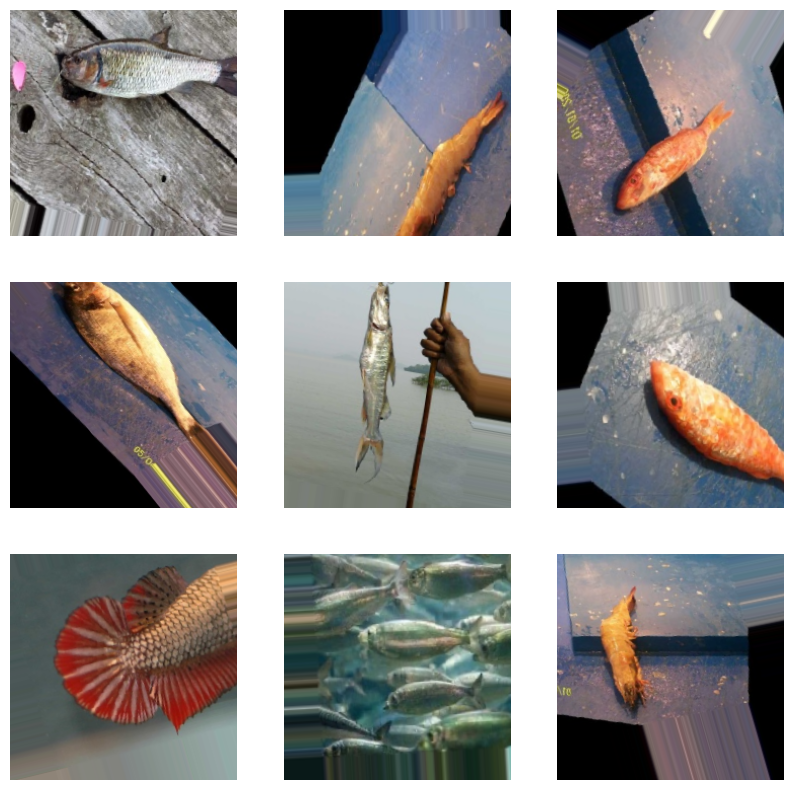

In [ ]:
# Augmented data generator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Re-creating train generator with augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Val and test generators without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Data generators created with augmentation for training.")
print(f"Train samples: {train_generator.samples}")
print(f"Val samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Visualize augmented images
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()

## CNN Model Training

In [ ]:
# Build CNN model
def build_cnn_scratch():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_scratch()
cnn_model.summary()

# Callbacks
checkpoint = ModelCheckpoint('cnn_scratch_best.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history_cnn = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)

print("CNN from scratch training complete. Best model saved as 'cnn_scratch_best.h5'.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,401,739 (169.38 MB)

 Trainable params: 44,401,739 (169.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.2736 - loss: 2.3048

195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 459ms/step - accuracy: 0.2742 - loss: 2.3022 - val_accuracy: 0.5778 - val_loss: 1.1603
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.5396 - loss: 1.2695

195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 457ms/step - accuracy: 0.5397 - loss: 1.2690 - val_accuracy: 0.7445 - val_loss: 0.7984
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.6457 - loss: 0.9786

195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 449ms/step - accuracy: 0.6457 - loss: 0.9784 - val_accuracy: 0.8278 - val_loss: 0.5879
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 421ms/step - accuracy: 0.7176 - loss: 0.8017 - val_accuracy: 0.8049 - val_loss: 0.5827
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7704 - loss: 0.6579

195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 462ms/step - accuracy: 0.7705 - loss: 0.6578 - val_accuracy: 0.8608 - val_loss: 0.4184
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7950 - loss: 0.5516

195/195 ━━━━━━━━━━━━━━━━━━━━ 88s 451ms/step - accuracy: 0.7951 - loss: 0.5516 - val_accuracy: 0.8654 - val_loss: 0.4206
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7969 - loss: 0.5496

195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 500ms/step - accuracy: 0.7970 - loss: 0.5496 - val_accuracy: 0.8791 - val_loss: 0.3753
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8159 - loss: 0.5204

195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 428ms/step - accuracy: 0.8159 - loss: 0.5203 - val_accuracy: 0.8956 - val_loss: 0.3033
Epoch 9/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8324 - loss: 0.4517

195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 447ms/step - accuracy: 0.8324 - loss: 0.4516 - val_accuracy: 0.9066 - val_loss: 0.3064
Epoch 10/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8531 - loss: 0.4162

195/195 ━━━━━━━━━━━━━━━━━━━━ 88s 448ms/step - accuracy: 0.8531 - loss: 0.4162 - val_accuracy: 0.9176 - val_loss: 0.2851
Epoch 11/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8410 - loss: 0.4245

195/195 ━━━━━━━━━━━━━━━━━━━━ 128s 659ms/step - accuracy: 0.8410 - loss: 0.4244 - val_accuracy: 0.9313 - val_loss: 0.2167
Epoch 12/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8692 - loss: 0.3652

195/195 ━━━━━━━━━━━━━━━━━━━━ 120s 616ms/step - accuracy: 0.8692 - loss: 0.3652 - val_accuracy: 0.9579 - val_loss: 0.1820
Epoch 13/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8797 - loss: 0.3416

195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 424ms/step - accuracy: 0.8797 - loss: 0.3416 - val_accuracy: 0.9698 - val_loss: 0.1550
Epoch 14/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 408ms/step - accuracy: 0.8951 - loss: 0.3078 - val_accuracy: 0.9588 - val_loss: 0.1553
Epoch 15/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 406ms/step - accuracy: 0.9096 - loss: 0.2744 - val_accuracy: 0.9469 - val_loss: 0.1885
Epoch 16/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 406ms/step - accuracy: 0.8935 - loss: 0.3155 - val_accuracy: 0.9634 - val_loss: 0.1403
Epoch 17/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9147 - loss: 0.2395

195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 463ms/step - accuracy: 0.9147 - loss: 0.2395 - val_accuracy: 0.9753 - val_loss: 0.1057
Epoch 18/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 406ms/step - accuracy: 0.9044 - loss: 0.2663 - val_accuracy: 0.9570 - val_loss: 0.1239
Epoch 19/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 404ms/step - accuracy: 0.9192 - loss: 0.2395 - val_accuracy: 0.9753 - val_loss: 0.1208
Epoch 20/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 407ms/step - accuracy: 0.9247 - loss: 0.2217 - val_accuracy: 0.9679 - val_loss: 0.1224
Epoch 21/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9238 - loss: 0.2222

195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 439ms/step - accuracy: 0.9238 - loss: 0.2223 - val_accuracy: 0.9789 - val_loss: 0.1115
Epoch 22/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 405ms/step - accuracy: 0.9222 - loss: 0.2233 - val_accuracy: 0.9725 - val_loss: 0.1139
Epoch 23/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9410 - loss: 0.1830

195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - accuracy: 0.9410 - loss: 0.1830 - val_accuracy: 0.9826 - val_loss: 0.0861
Epoch 24/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 411ms/step - accuracy: 0.9404 - loss: 0.1686 - val_accuracy: 0.9771 - val_loss: 0.0851
Epoch 25/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 404ms/step - accuracy: 0.9441 - loss: 0.1687 - val_accuracy: 0.9789 - val_loss: 0.0890
Epoch 26/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 407ms/step - accuracy: 0.9342 - loss: 0.1944 - val_accuracy: 0.9762 - val_loss: 0.1033
Epoch 27/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 405ms/step - accuracy: 0.9420 - loss: 0.1791 - val_accuracy: 0.9679 - val_loss: 0.1092
Epoch 28/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 408ms/step - accuracy: 0.9395 - loss: 0.1898 - val_accuracy: 0.9789 - val_loss: 0.0930
Epoch 29/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 404ms/step - accuracy: 0.9533 - loss: 0.1397 - val_accuracy: 0.9817 - val_loss: 0.0844
Epoch 30/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 406ms/step - accuracy: 0.9388 - loss: 0.169

195/195 ━━━━━━━━━━━━━━━━━━━━ 92s 471ms/step - accuracy: 0.9502 - loss: 0.1487 - val_accuracy: 0.9844 - val_loss: 0.0751
Epoch 33/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 406ms/step - accuracy: 0.9507 - loss: 0.1544 - val_accuracy: 0.9780 - val_loss: 0.0925
Epoch 34/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9449 - loss: 0.1551

195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 444ms/step - accuracy: 0.9449 - loss: 0.1551 - val_accuracy: 0.9863 - val_loss: 0.0704
Epoch 35/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 408ms/step - accuracy: 0.9485 - loss: 0.1606 - val_accuracy: 0.9863 - val_loss: 0.0577
Epoch 36/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 401ms/step - accuracy: 0.9494 - loss: 0.1466 - val_accuracy: 0.9844 - val_loss: 0.0528
Epoch 37/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 403ms/step - accuracy: 0.9518 - loss: 0.1590 - val_accuracy: 0.9615 - val_loss: 0.1424
Epoch 38/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 405ms/step - accuracy: 0.9468 - loss: 0.1632 - val_accuracy: 0.9762 - val_loss: 0.1150
Epoch 39/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 405ms/step - accuracy: 0.9523 - loss: 0.1350 - val_accuracy: 0.9863 - val_loss: 0.0591
Epoch 40/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 409ms/step - accuracy: 0.9616 - loss: 0.1180 - val_accuracy: 0.9606 - val_loss: 0.1185
Epoch 41/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 407ms/step - accuracy: 0.9637 - loss: 0.116

195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 442ms/step - accuracy: 0.9514 - loss: 0.1385 - val_accuracy: 0.9872 - val_loss: 0.0698
CNN from scratch training complete. Best model saved as 'cnn_scratch_best.h5'.


## Model Training - Transfer Learning with Pre-trained Models

In [ ]:
# Function to build and train transfer learning model
def build_transfer_model(base_model_name):
    if base_model_name == 'VGG16':
        base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif base_model_name == 'ResNet50':
        base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif base_model_name == 'MobileNet':
        base = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif base_model_name == 'InceptionV3':
        base = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    elif base_model_name == 'EfficientNetB0':
        base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    base.trainable = False  # Freeze base model
    model = Sequential([
        base,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Fine-tune: Unfreeze some layers
    base.trainable = True
    fine_tune_at = len(base.layers) // 2
    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train each pre-trained model
models = {}
histories = {}
pretrained_names = ['VGG16', 'ResNet50', 'MobileNet', 'InceptionV3', 'EfficientNetB0']

for name in pretrained_names:
    print(f"Training {name}...")
    model = build_transfer_model(name)
    checkpoint = ModelCheckpoint(f'{name}_best.h5', monitor='val_accuracy', save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stop]
    )
    models[name] = model
    histories[name] = history

# Including CNN history from Step 4 for comparison
histories['CNN_Scratch'] = history_cnn

print("Transfer learning training complete. Best models saved as '{model_name}_best.h5'.")

Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.3906 - loss: 1.7284

195/195 ━━━━━━━━━━━━━━━━━━━━ 162s 677ms/step - accuracy: 0.3915 - loss: 1.7257 - val_accuracy: 0.8929 - val_loss: 0.3297
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8855 - loss: 0.3695

195/195 ━━━━━━━━━━━━━━━━━━━━ 102s 521ms/step - accuracy: 0.8856 - loss: 0.3691 - val_accuracy: 0.9698 - val_loss: 0.1088
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9587 - loss: 0.1417

195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 520ms/step - accuracy: 0.9586 - loss: 0.1418 - val_accuracy: 0.9707 - val_loss: 0.0862
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 515ms/step - accuracy: 0.9693 - loss: 0.1022 - val_accuracy: 0.9478 - val_loss: 0.1562
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 511ms/step - accuracy: 0.9681 - loss: 0.1190 - val_accuracy: 0.9634 - val_loss: 0.1072
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9785 - loss: 0.0678

195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 539ms/step - accuracy: 0.9784 - loss: 0.0679 - val_accuracy: 0.9863 - val_loss: 0.0489
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 512ms/step - accuracy: 0.9850 - loss: 0.0535 - val_accuracy: 0.9240 - val_loss: 0.2425
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9739 - loss: 0.0817

195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 539ms/step - accuracy: 0.9740 - loss: 0.0816 - val_accuracy: 0.9872 - val_loss: 0.0464
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 513ms/step - accuracy: 0.9819 - loss: 0.0666 - val_accuracy: 0.9808 - val_loss: 0.0604
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 515ms/step - accuracy: 0.9773 - loss: 0.0693 - val_accuracy: 0.9835 - val_loss: 0.0802
Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.1726 - loss: 3.2848

195/195 ━━━━━━━━━━━━━━━━━━━━ 165s 649ms/step - accuracy: 0.1727 - loss: 3.2808 - val_accuracy: 0.1804 - val_loss: 2.3408
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.2063 - loss: 2.2176

195/195 ━━━━━━━━━━━━━━━━━━━━ 106s 545ms/step - accuracy: 0.2063 - loss: 2.2176 - val_accuracy: 0.2875 - val_loss: 2.0428
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.2709 - loss: 2.0679

195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 503ms/step - accuracy: 0.2711 - loss: 2.0676 - val_accuracy: 0.4002 - val_loss: 1.6722
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 457ms/step - accuracy: 0.3476 - loss: 1.8454 - val_accuracy: 0.3782 - val_loss: 2.1235
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4410 - loss: 1.5497

195/195 ━━━━━━━━━━━━━━━━━━━━ 107s 549ms/step - accuracy: 0.4411 - loss: 1.5494 - val_accuracy: 0.5192 - val_loss: 1.4760
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 456ms/step - accuracy: 0.5759 - loss: 1.2201 - val_accuracy: 0.5082 - val_loss: 2.0094
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 461ms/step - accuracy: 0.6622 - loss: 0.9889 - val_accuracy: 0.2958 - val_loss: 6.3614
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 458ms/step - accuracy: 0.7804 - loss: 0.6960 - val_accuracy: 0.3910 - val_loss: 5.2144
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8358 - loss: 0.5598

195/195 ━━━━━━━━━━━━━━━━━━━━ 146s 481ms/step - accuracy: 0.8358 - loss: 0.5597 - val_accuracy: 0.8242 - val_loss: 0.5040
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8726 - loss: 0.4307

195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 508ms/step - accuracy: 0.8726 - loss: 0.4306 - val_accuracy: 0.8443 - val_loss: 0.4853
Training MobileNet...
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6122 - loss: 1.8956

195/195 ━━━━━━━━━━━━━━━━━━━━ 132s 553ms/step - accuracy: 0.6130 - loss: 1.8904 - val_accuracy: 0.9817 - val_loss: 0.0668
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9414 - loss: 0.1919

195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 420ms/step - accuracy: 0.9414 - loss: 0.1917 - val_accuracy: 0.9872 - val_loss: 0.0309
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9639 - loss: 0.1113

195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 426ms/step - accuracy: 0.9640 - loss: 0.1113 - val_accuracy: 0.9936 - val_loss: 0.0230
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9747 - loss: 0.0828

195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 420ms/step - accuracy: 0.9747 - loss: 0.0828 - val_accuracy: 0.9963 - val_loss: 0.0085
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9823 - loss: 0.0522

195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 418ms/step - accuracy: 0.9823 - loss: 0.0521 - val_accuracy: 0.9973 - val_loss: 0.0106
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 411ms/step - accuracy: 0.9846 - loss: 0.0544 - val_accuracy: 0.9963 - val_loss: 0.0235
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 406ms/step - accuracy: 0.9859 - loss: 0.0390 - val_accuracy: 0.9963 - val_loss: 0.0177
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 407ms/step - accuracy: 0.9851 - loss: 0.0508 - val_accuracy: 0.9954 - val_loss: 0.0084
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 408ms/step - accuracy: 0.9905 - loss: 0.0323 - val_accuracy: 0.9963 - val_loss: 0.0093
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9849 - loss: 0.0553

195/195 ━━━━━━━━━━━━━━━━━━━━ 84s 428ms/step - accuracy: 0.9849 - loss: 0.0553 - val_accuracy: 0.9982 - val_loss: 0.0110
Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6255 - loss: 1.2804

195/195 ━━━━━━━━━━━━━━━━━━━━ 179s 678ms/step - accuracy: 0.6265 - loss: 1.2770 - val_accuracy: 0.9789 - val_loss: 0.0645
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9580 - loss: 0.1356

195/195 ━━━━━━━━━━━━━━━━━━━━ 137s 481ms/step - accuracy: 0.9580 - loss: 0.1356 - val_accuracy: 0.9918 - val_loss: 0.0311
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9838 - loss: 0.0572

195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 494ms/step - accuracy: 0.9838 - loss: 0.0572 - val_accuracy: 0.9927 - val_loss: 0.0231
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9839 - loss: 0.0504

195/195 ━━━━━━━━━━━━━━━━━━━━ 95s 487ms/step - accuracy: 0.9839 - loss: 0.0504 - val_accuracy: 0.9963 - val_loss: 0.0077
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 438ms/step - accuracy: 0.9855 - loss: 0.0481 - val_accuracy: 0.9927 - val_loss: 0.0272
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 84s 431ms/step - accuracy: 0.9823 - loss: 0.0651 - val_accuracy: 0.9945 - val_loss: 0.0299
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 441ms/step - accuracy: 0.9888 - loss: 0.0365 - val_accuracy: 0.9963 - val_loss: 0.0254
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 84s 432ms/step - accuracy: 0.9882 - loss: 0.0360 - val_accuracy: 0.9963 - val_loss: 0.0158
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9882 - loss: 0.0540

195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 461ms/step - accuracy: 0.9882 - loss: 0.0540 - val_accuracy: 0.9982 - val_loss: 0.0134
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 85s 436ms/step - accuracy: 0.9906 - loss: 0.0330 - val_accuracy: 0.9982 - val_loss: 0.0057
Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.2180 - loss: 2.6670

195/195 ━━━━━━━━━━━━━━━━━━━━ 183s 665ms/step - accuracy: 0.2182 - loss: 2.6646 - val_accuracy: 0.1712 - val_loss: 2.3435
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.3751 - loss: 1.7637 - val_accuracy: 0.1712 - val_loss: 9.8297
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.4776 - loss: 1.4644

195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 441ms/step - accuracy: 0.4776 - loss: 1.4642 - val_accuracy: 0.1987 - val_loss: 4.1047
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.5252 - loss: 1.3206

195/195 ━━━━━━━━━━━━━━━━━━━━ 91s 466ms/step - accuracy: 0.5253 - loss: 1.3204 - val_accuracy: 0.2875 - val_loss: 3.5964
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.5994 - loss: 1.1688

195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 446ms/step - accuracy: 0.5995 - loss: 1.1686 - val_accuracy: 0.7637 - val_loss: 0.6355
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 414ms/step - accuracy: 0.6490 - loss: 0.9951 - val_accuracy: 0.2079 - val_loss: 5.4621
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.6916 - loss: 0.8850

195/195 ━━━━━━━━━━━━━━━━━━━━ 94s 480ms/step - accuracy: 0.6916 - loss: 0.8849 - val_accuracy: 0.7866 - val_loss: 0.5994
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 424ms/step - accuracy: 0.7234 - loss: 0.8161 - val_accuracy: 0.2674 - val_loss: 3.4016
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7505 - loss: 0.7236

195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 441ms/step - accuracy: 0.7505 - loss: 0.7234 - val_accuracy: 0.9057 - val_loss: 0.3072
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 425ms/step - accuracy: 0.7695 - loss: 0.6748 - val_accuracy: 0.4789 - val_loss: 3.1052
Transfer learning training complete. Best models saved as '{model_name}_best.h5'.


## Model Evaluation and Comparison

Evaluating VGG16 on Validation...
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step
Validation Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.96      0.97       187
                animal fish bass       0.58      0.70      0.64        10
   fish sea_food black_sea_sprat       1.00      1.00      1.00       105
   fish sea_food gilt_head_bream       1.00      0.99      0.99        94
   fish sea_food hourse_mackerel       1.00      1.00      1.00        97
        fish sea_food red_mullet       0.98      1.00      0.99        90
     fish sea_food red_sea_bream       0.99      1.00      1.00       113
          fish sea_food sea_bass       1.00      1.00      1.00        97
            fish sea_food shrimp       1.00      1.00      1.00       100
fish sea_food striped_red_mullet       0.98      0.98      0.98       101
             fish sea_food trout       0.99      1.00      0.99        98

 

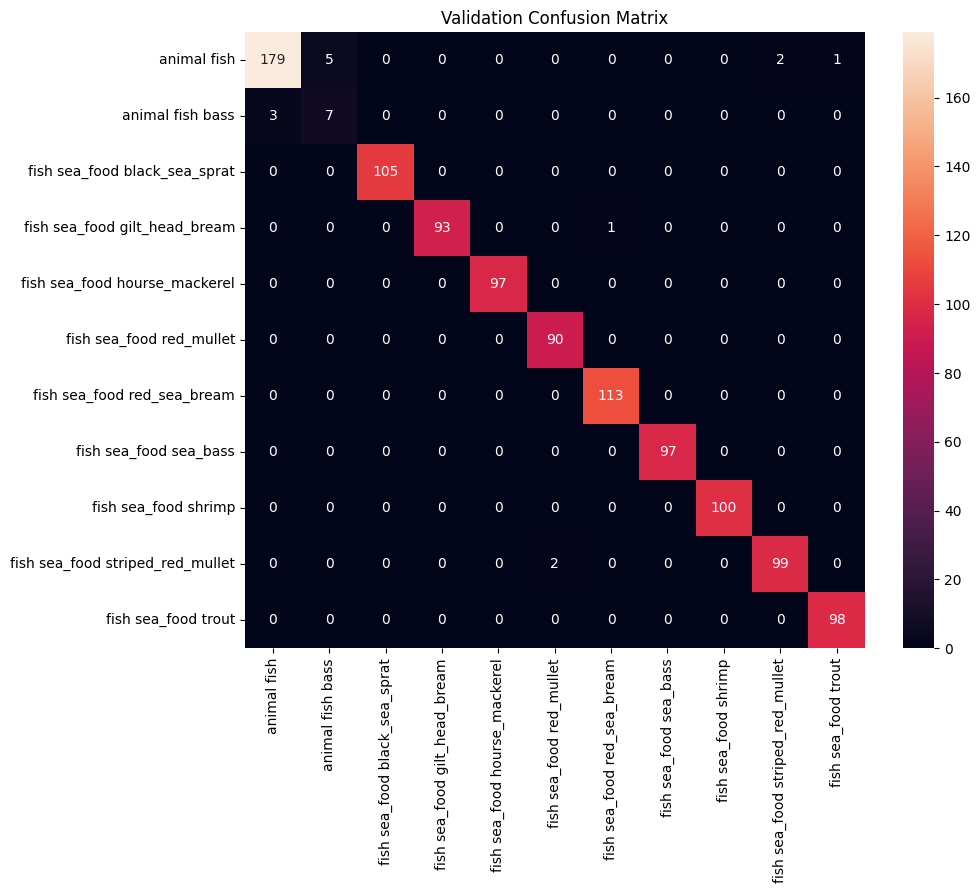

Evaluating ResNet50 on Validation...
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
Validation Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.89      0.98      0.94       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.81      0.98      0.89       105
   fish sea_food gilt_head_bream       0.98      0.90      0.94        94
   fish sea_food hourse_mackerel       0.81      0.71      0.76        97
        fish sea_food red_mullet       0.62      1.00      0.77        90
     fish sea_food red_sea_bream       0.97      0.83      0.90       113
          fish sea_food sea_bass       1.00      0.57      0.72        97
            fish sea_food shrimp       1.00      0.81      0.90       100
fish sea_food striped_red_mullet       0.59      0.67      0.63       101
             fish sea_food trout       1.00      0.95      0.97        98

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

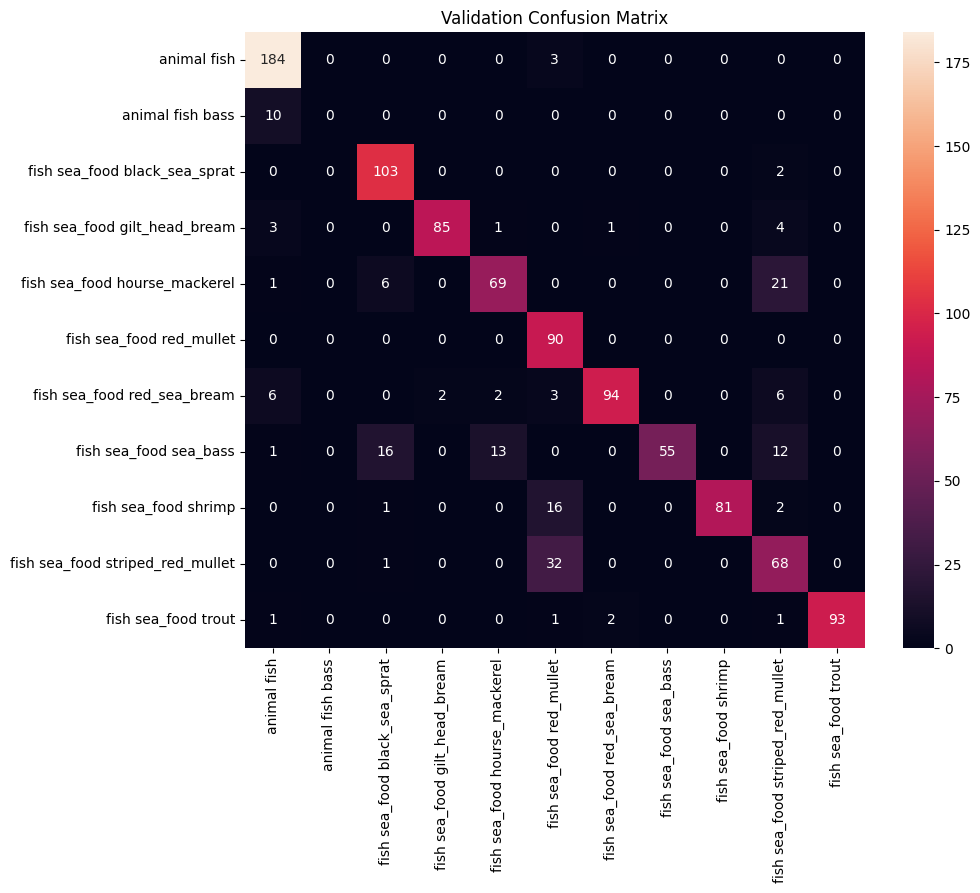

Evaluating MobileNet on Validation...
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
Validation Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.99      0.99      0.99       187
                animal fish bass       1.00      0.90      0.95        10
   fish sea_food black_sea_sprat       1.00      1.00      1.00       105
   fish sea_food gilt_head_bream       1.00      1.00      1.00        94
   fish sea_food hourse_mackerel       1.00      1.00      1.00        97
        fish sea_food red_mullet       1.00      1.00      1.00        90
     fish sea_food red_sea_bream       1.00      1.00      1.00       113
          fish sea_food sea_bass       0.99      1.00      0.99        97
            fish sea_food shrimp       1.00      1.00      1.00       100
fish sea_food striped_red_mullet       1.00      1.00      1.00       101
             fish sea_food trout       1.00      1.00      1.00        98

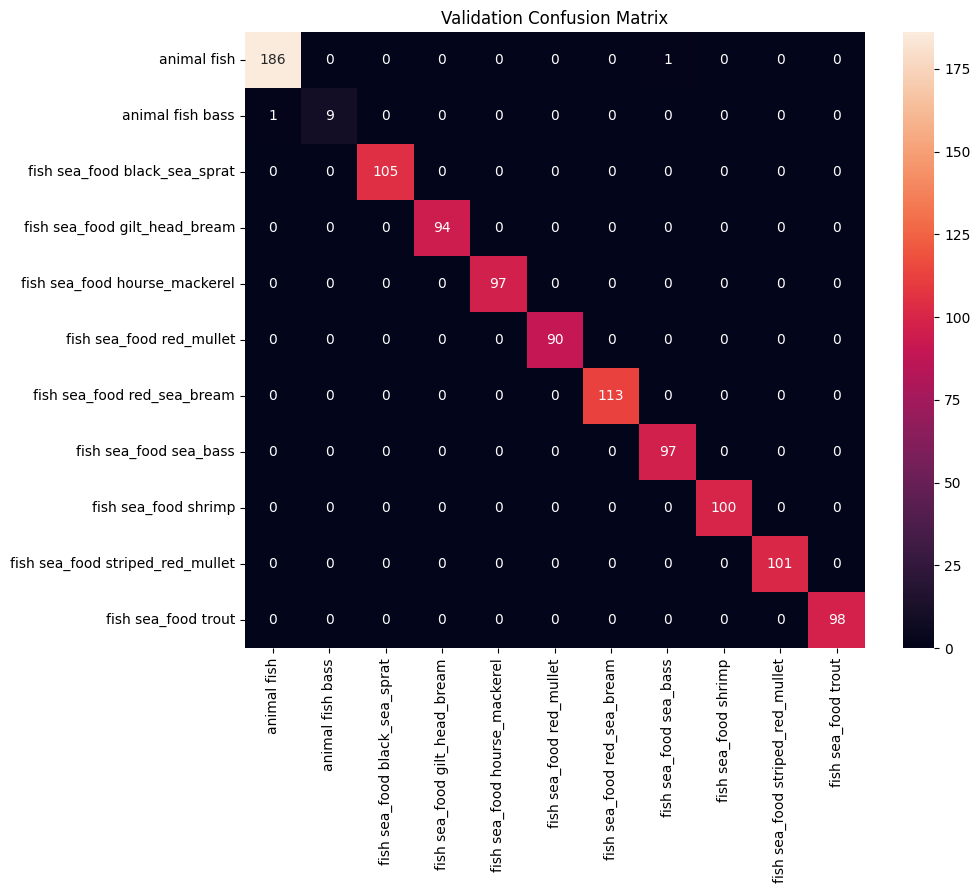

Evaluating InceptionV3 on Validation...
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
Validation Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      1.00       187
                animal fish bass       1.00      0.90      0.95        10
   fish sea_food black_sea_sprat       1.00      1.00      1.00       105
   fish sea_food gilt_head_bream       1.00      0.99      0.99        94
   fish sea_food hourse_mackerel       1.00      1.00      1.00        97
        fish sea_food red_mullet       1.00      1.00      1.00        90
     fish sea_food red_sea_bream       0.99      1.00      1.00       113
          fish sea_food sea_bass       1.00      1.00      1.00        97
            fish sea_food shrimp       1.00      1.00      1.00       100
fish sea_food striped_red_mullet       1.00      1.00      1.00       101
             fish sea_food trout       1.00      1.00      1.00        

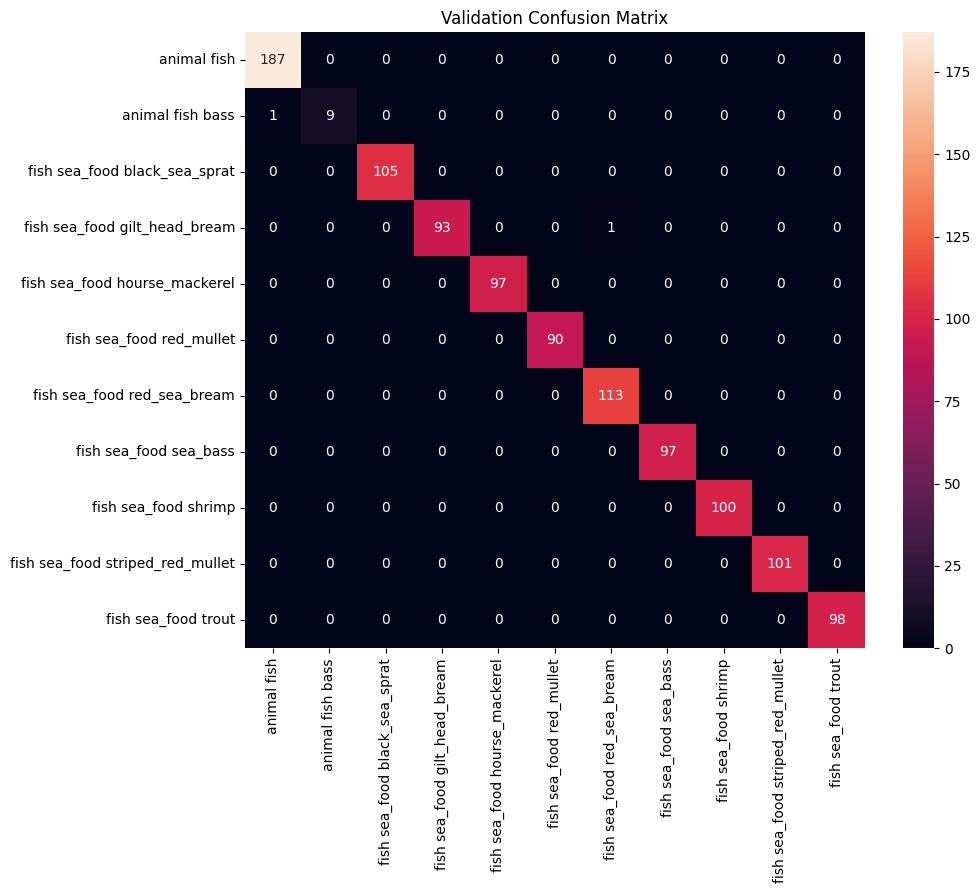

Evaluating EfficientNetB0 on Validation...
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Validation Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.95      0.99      0.97       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.99      0.98      0.99       105
   fish sea_food gilt_head_bream       0.92      0.85      0.88        94
   fish sea_food hourse_mackerel       0.78      0.97      0.87        97
        fish sea_food red_mullet       1.00      0.88      0.93        90
     fish sea_food red_sea_bream       0.96      0.88      0.92       113
          fish sea_food sea_bass       0.97      0.90      0.93        97
            fish sea_food shrimp       0.98      0.96      0.97       100
fish sea_food striped_red_mullet       0.85      0.67      0.75       101
             fish sea_food trout       0.72      1.00      0.84     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

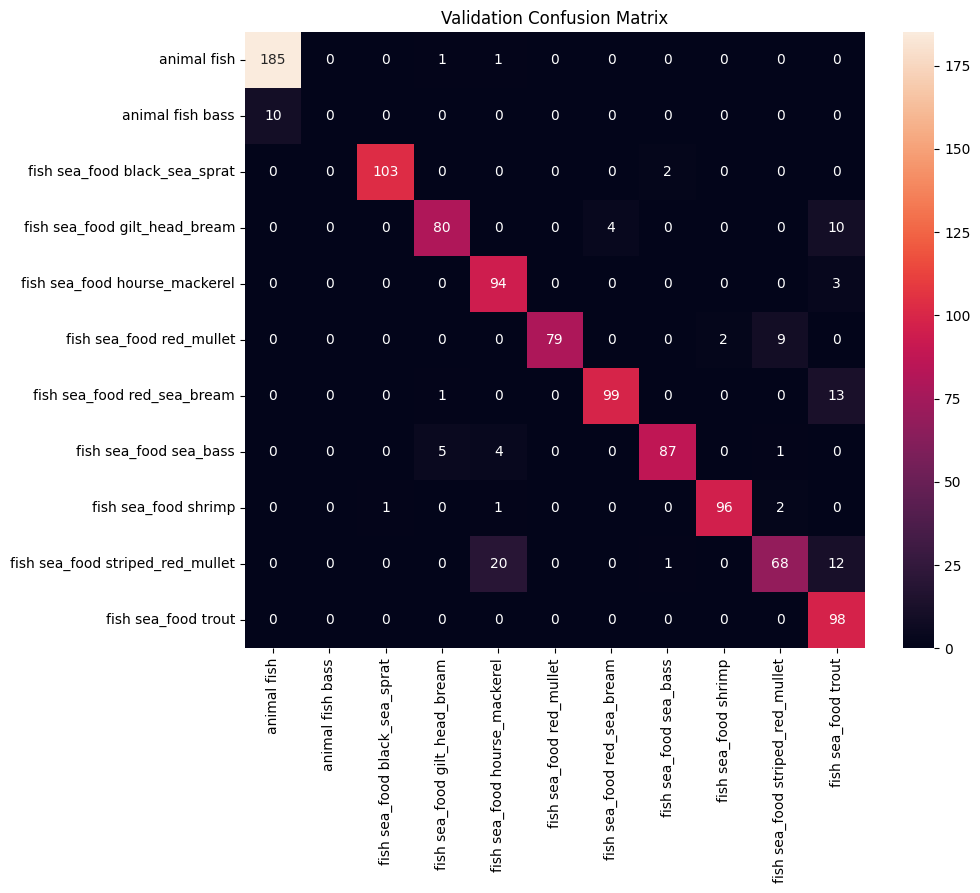

Evaluating CNN_Scratch on Validation...
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Validation Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.95      0.99      0.97       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.99      0.99      0.99       105
   fish sea_food gilt_head_bream       1.00      0.96      0.98        94
   fish sea_food hourse_mackerel       1.00      1.00      1.00        97
        fish sea_food red_mullet       1.00      1.00      1.00        90
     fish sea_food red_sea_bream       1.00      1.00      1.00       113
          fish sea_food sea_bass       0.95      0.99      0.97        97
            fish sea_food shrimp       1.00      1.00      1.00       100
fish sea_food striped_red_mullet       1.00      1.00      1.00       101
             fish sea_food trout       1.00      1.00      1.00        

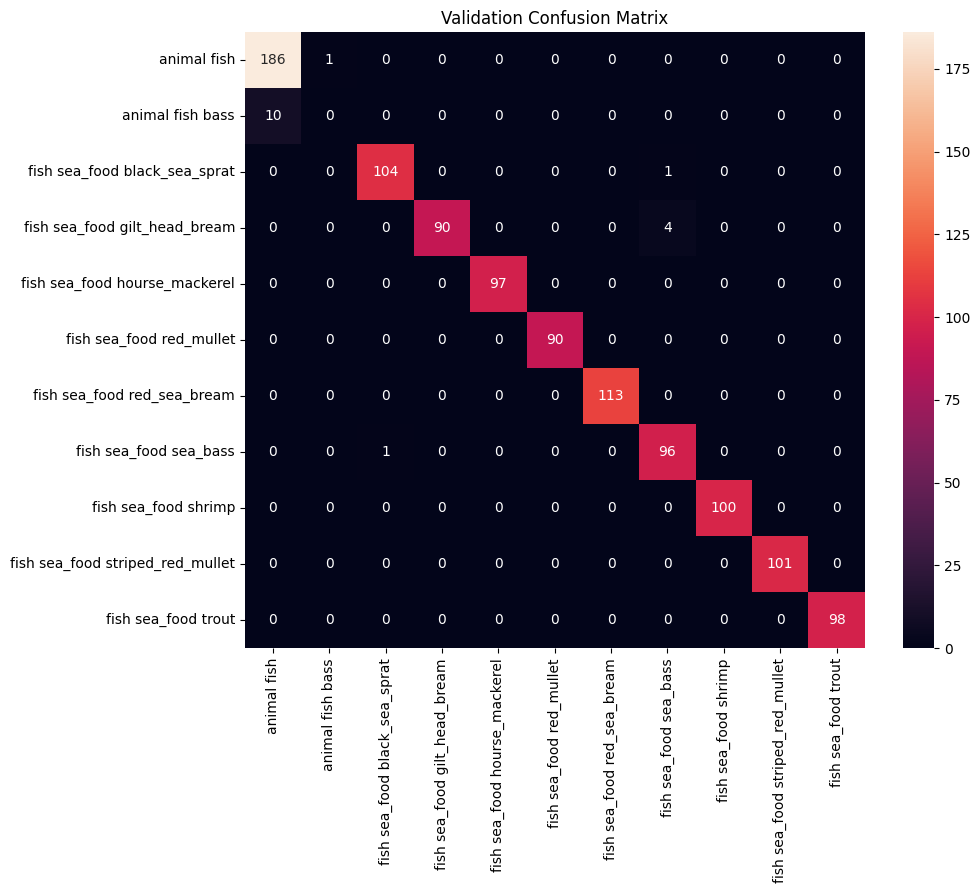

Evaluating VGG16 on Test...
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step
Test Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       1.00      0.98      0.99       520
                animal fish bass       0.59      0.77      0.67        13
   fish sea_food black_sea_sprat       0.99      1.00      0.99       298
   fish sea_food gilt_head_bream       0.99      0.99      0.99       305
   fish sea_food hourse_mackerel       1.00      0.99      1.00       286
        fish sea_food red_mullet       0.99      1.00      1.00       291
     fish sea_food red_sea_bream       0.99      1.00      1.00       273
          fish sea_food sea_bass       1.00      0.99      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      0.99      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

          

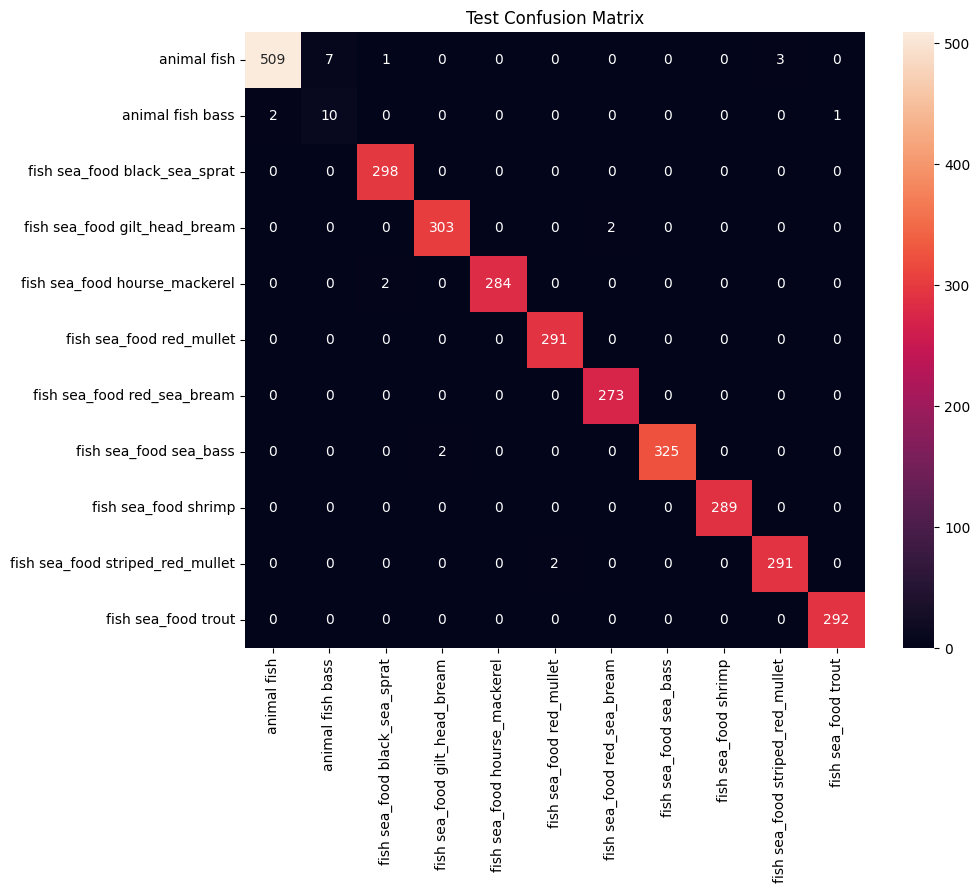

Evaluating ResNet50 on Test...
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step
Test Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.94      0.98      0.96       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.81      1.00      0.89       298
   fish sea_food gilt_head_bream       0.98      0.93      0.95       305
   fish sea_food hourse_mackerel       0.86      0.75      0.80       286
        fish sea_food red_mullet       0.70      1.00      0.83       291
     fish sea_food red_sea_bream       0.99      0.92      0.95       273
          fish sea_food sea_bass       1.00      0.69      0.81       327
            fish sea_food shrimp       0.99      0.90      0.94       289
fish sea_food striped_red_mullet       0.66      0.68      0.67       293
             fish sea_food trout       1.00      0.97      0.98       292

         

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

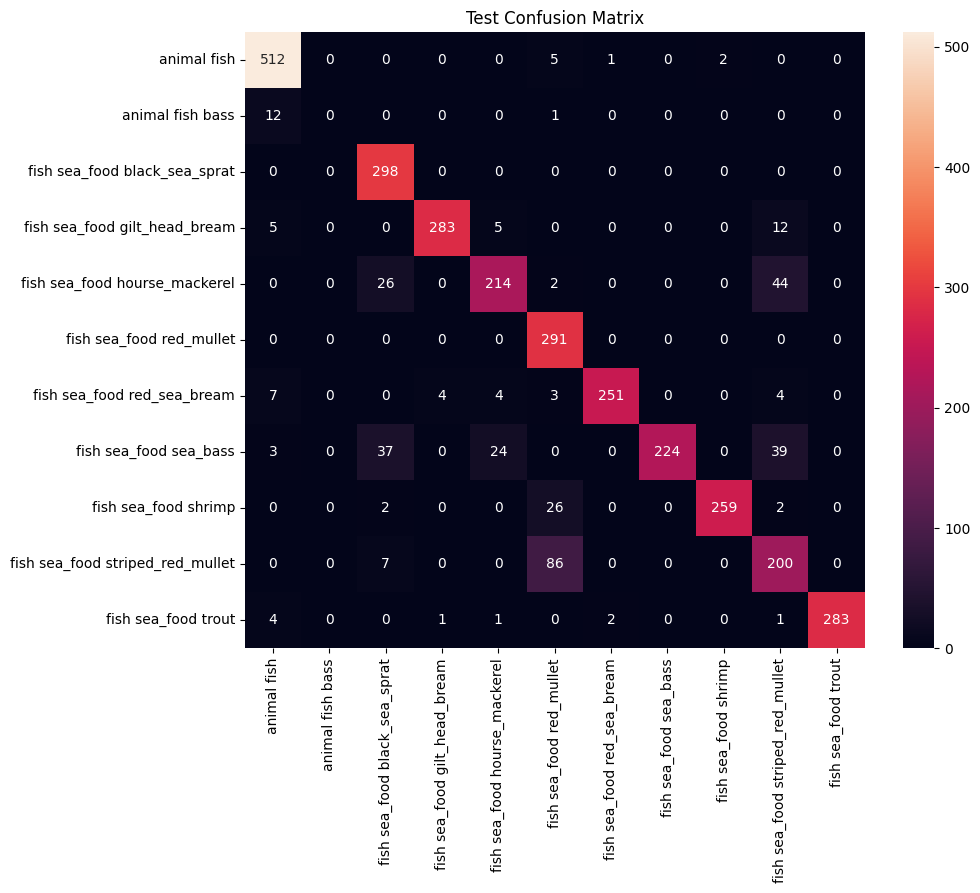

Evaluating MobileNet on Test...
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
Test Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      1.00       520
                animal fish bass       1.00      0.77      0.87        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

        

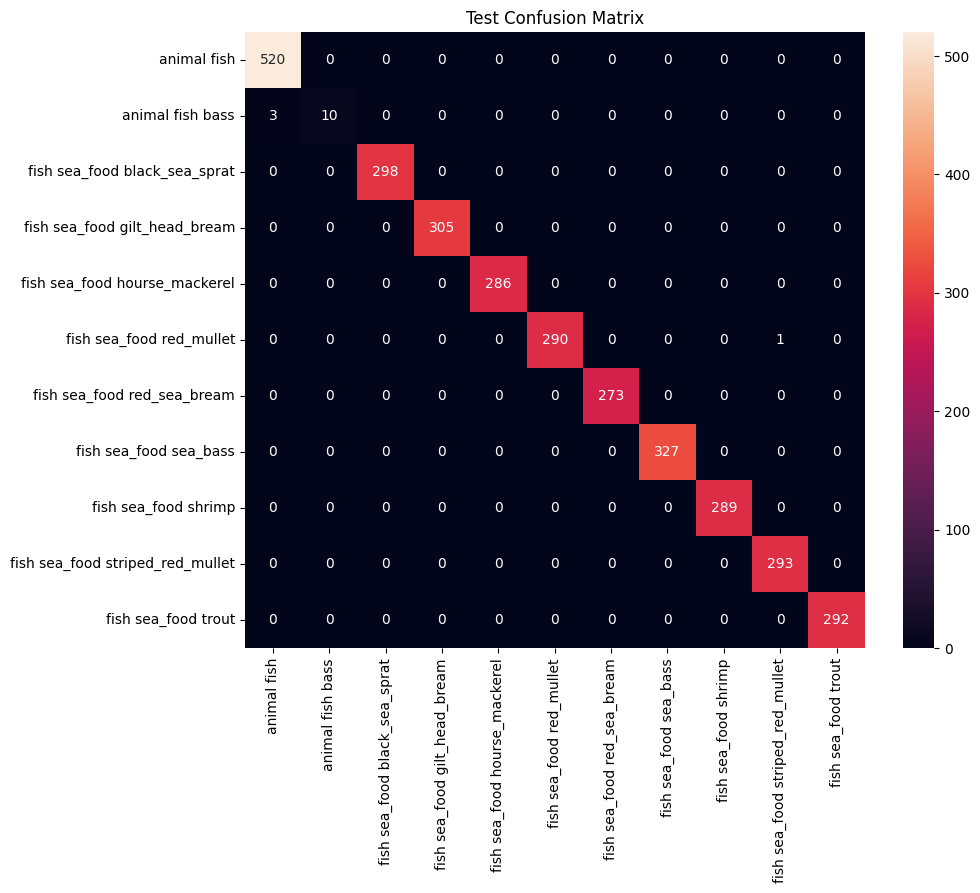

Evaluating InceptionV3 on Test...
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step
Test Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      1.00       520
                animal fish bass       1.00      0.77      0.87        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       0.99      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

      

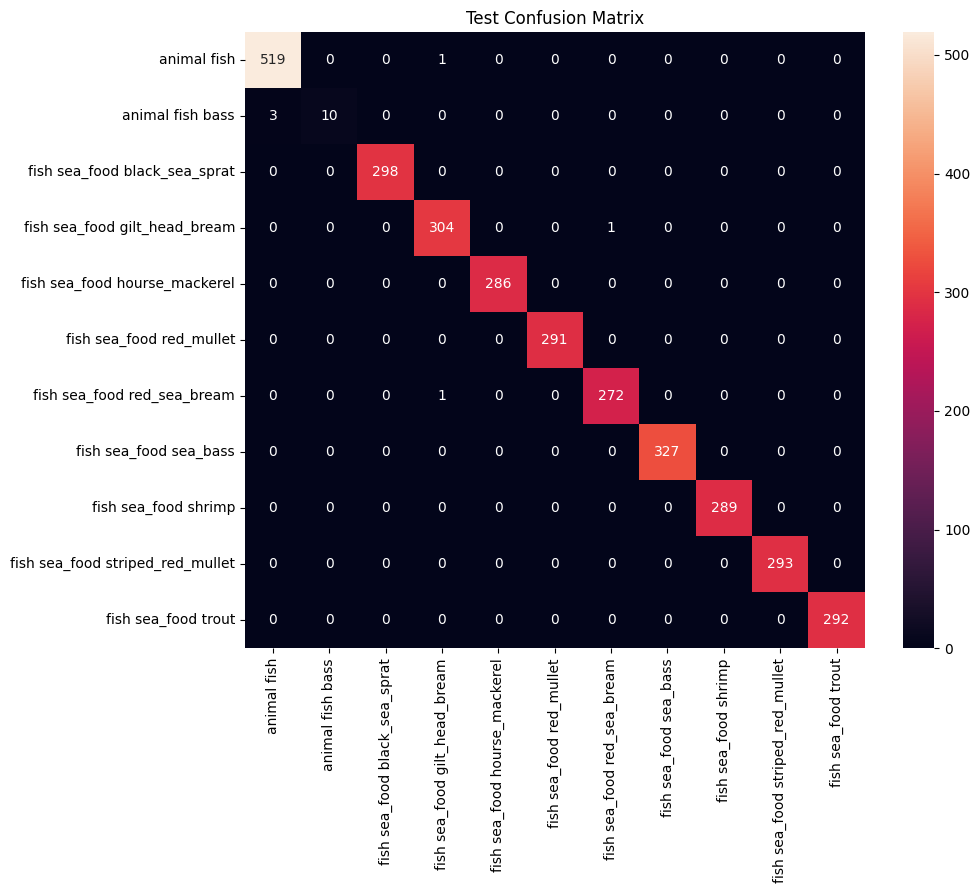

Evaluating EfficientNetB0 on Test...
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step
Test Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.98      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.99      0.98      0.98       298
   fish sea_food gilt_head_bream       0.88      0.85      0.86       305
   fish sea_food hourse_mackerel       0.72      0.95      0.82       286
        fish sea_food red_mullet       1.00      0.81      0.90       291
     fish sea_food red_sea_bream       0.92      0.92      0.92       273
          fish sea_food sea_bass       0.96      0.82      0.88       327
            fish sea_food shrimp       0.98      0.94      0.96       289
fish sea_food striped_red_mullet       0.77      0.66      0.71       293
             fish sea_food trout       0.77      1.00      0.87       292

   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

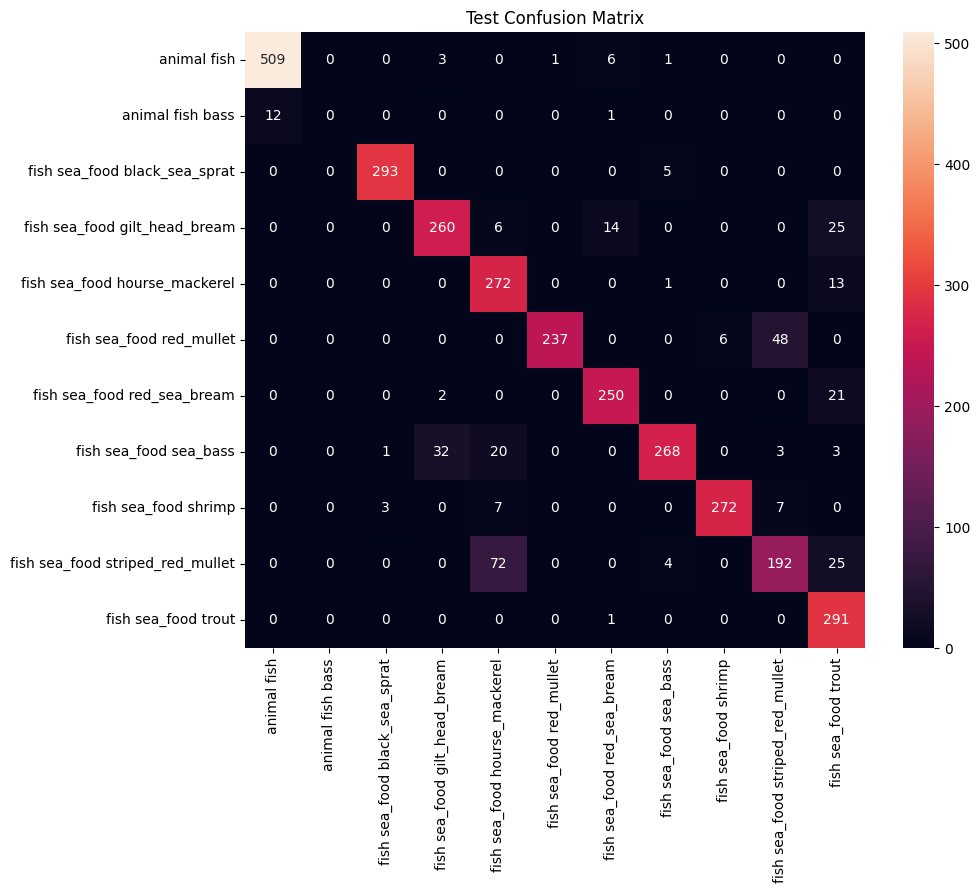

Evaluating CNN_Scratch on Test...
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
Test Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       0.67      0.15      0.25        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       0.99      0.90      0.94       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      0.99      0.99       291
     fish sea_food red_sea_bream       0.94      1.00      0.97       273
          fish sea_food sea_bass       0.95      1.00      0.97       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      0.99      0.99       293
             fish sea_food trout       0.99      0.99      0.99       292

      

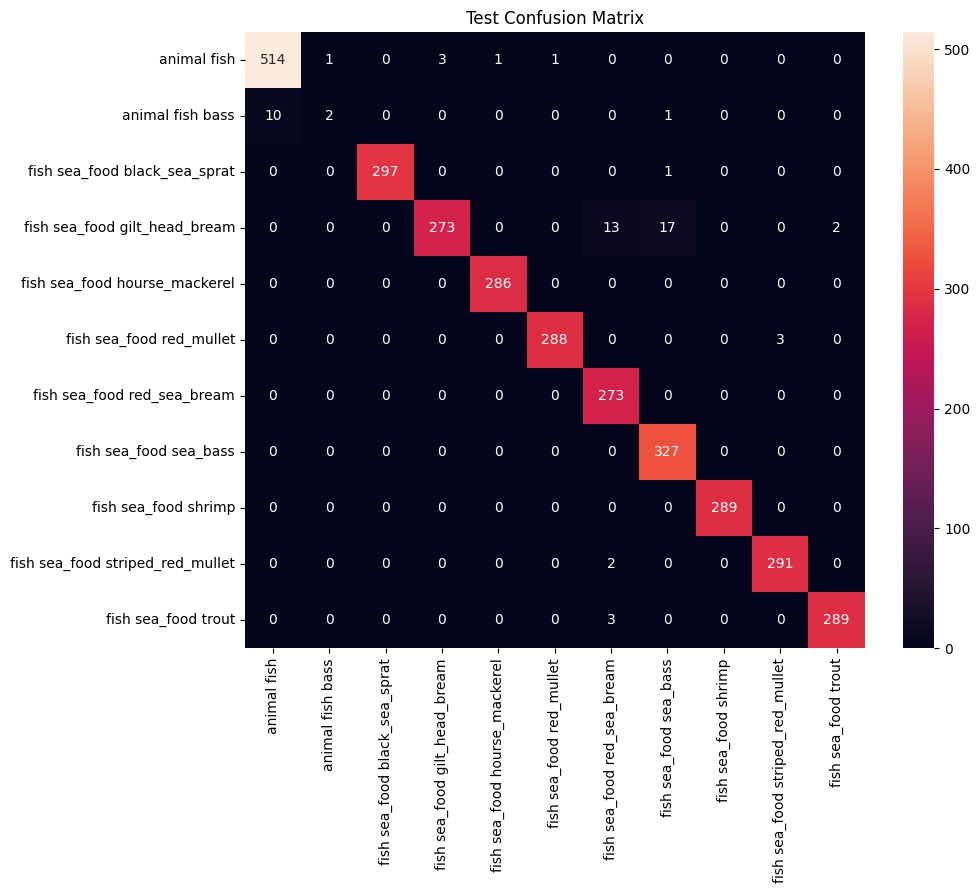


Model Comparison Summary:


,Model,Validation Accuracy,Validation Precision,Validation Recall,Validation F1-Score,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,VGG16,0.987179,0.987924,0.987179,0.987456,0.993097,0.993625,0.993097,0.993292
1,ResNet50,0.844322,0.862950,0.844322,0.841306,0.883276,0.894560,0.883276,0.881671
2,MobileNet,0.998168,0.998178,0.998168,0.998147,0.998745,0.998751,0.998745,0.998685
3,InceptionV3,0.998168,0.998181,0.998168,0.998145,0.998117,0.998123,0.998117,0.998058
4,EfficientNetB0,0.905678,0.907167,0.905678,0.901718,0.892375,0.898256,0.892375,0.890708
5,CNN_Scratch,0.984432,0.976792,0.984432,0.980445,0.981801,0.981357,0.981801,0.980532


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

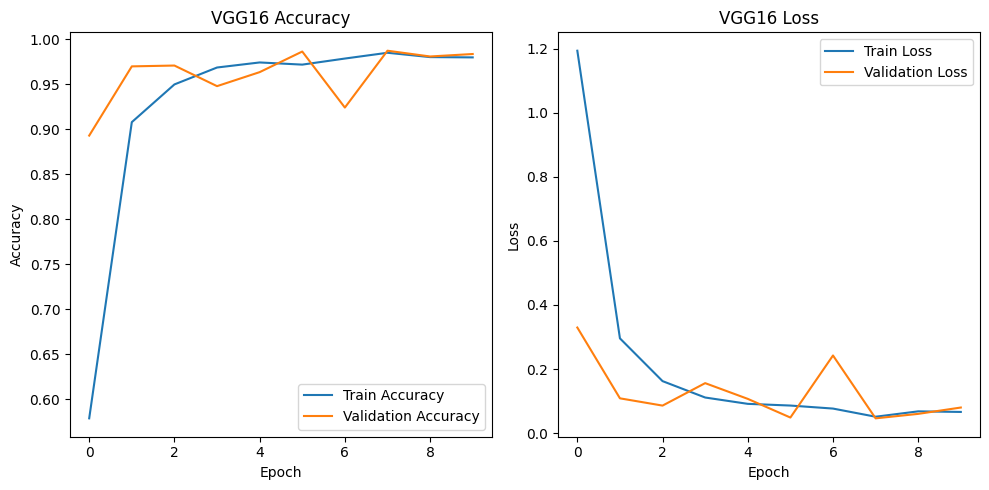

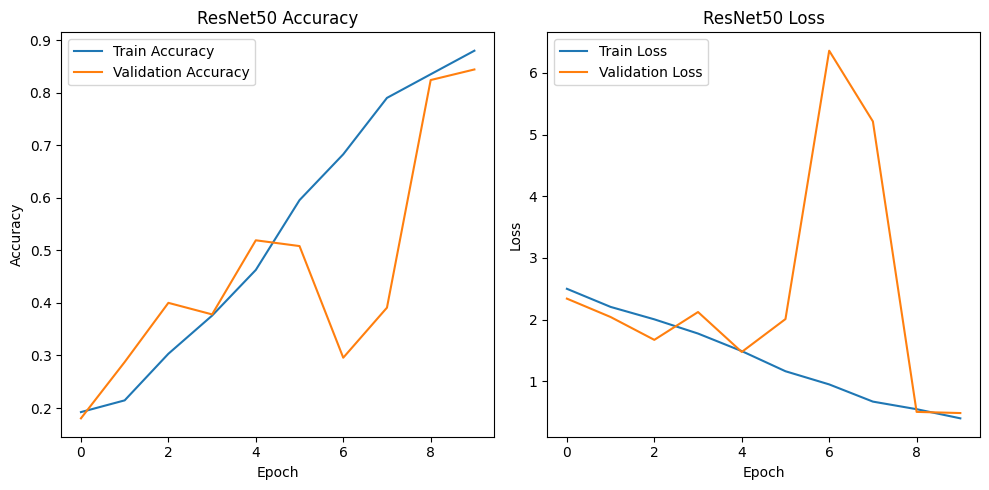

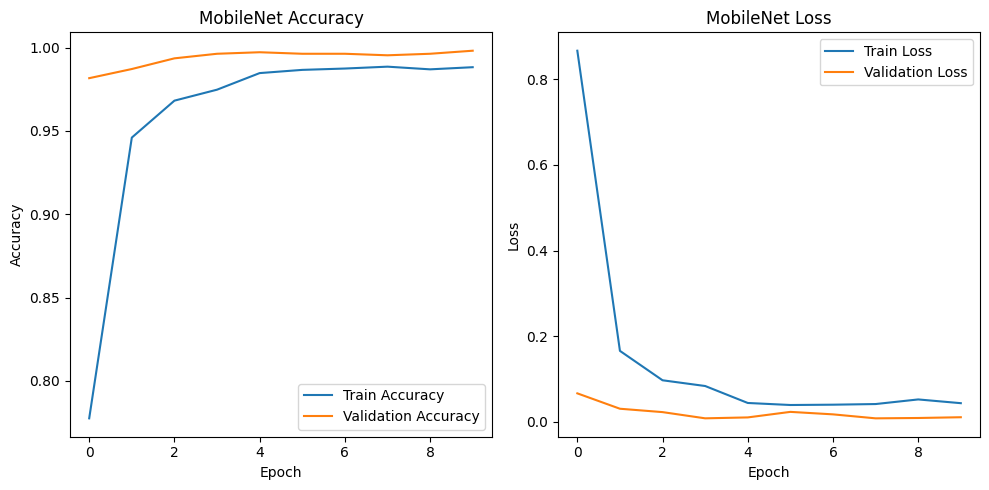

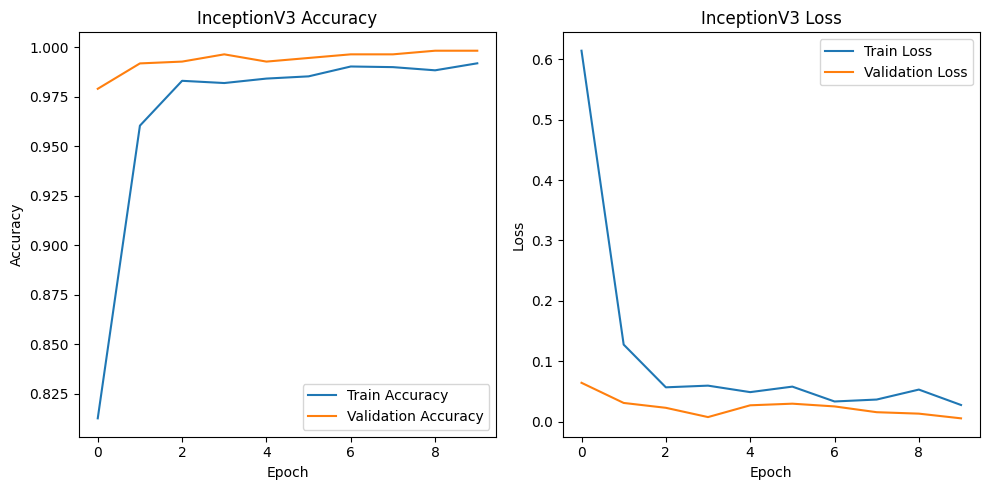

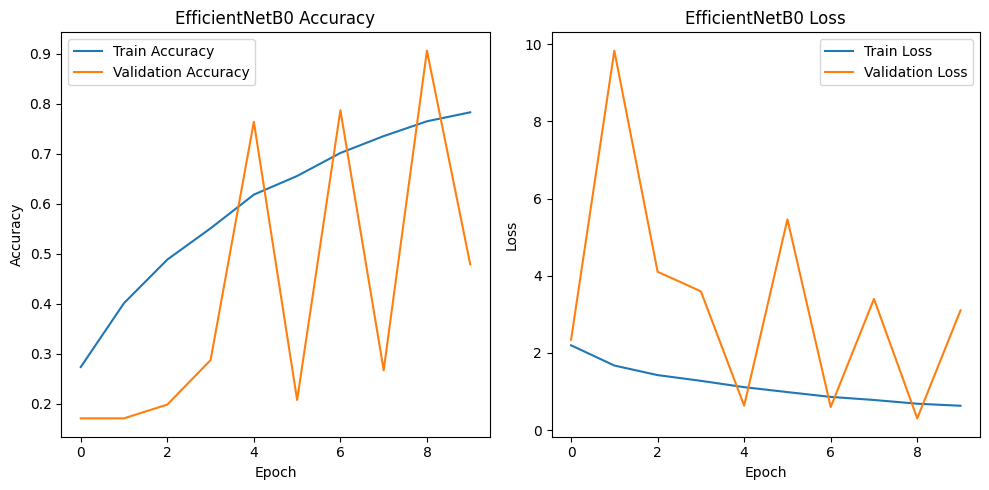

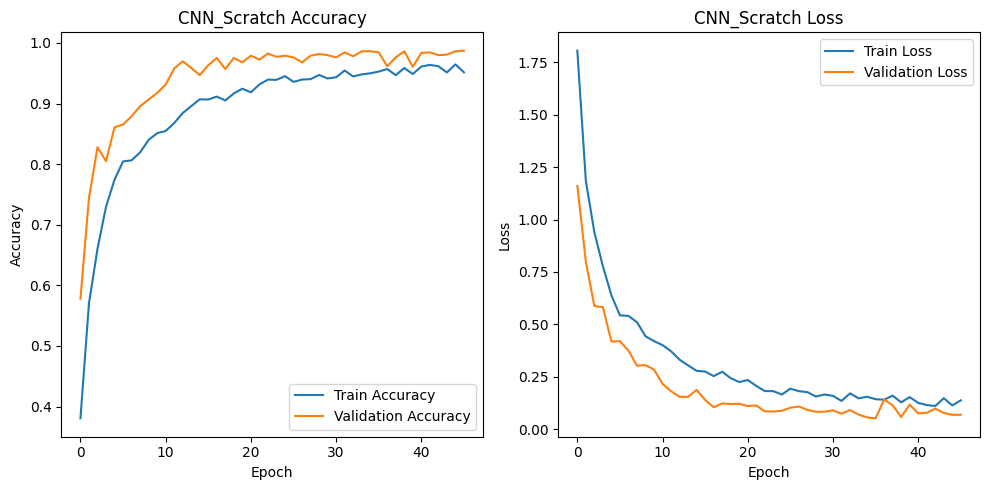

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evaluation complete. Best model (MobileNet) saved as 'best_fish_model.h5'.


In [ ]:
# Function to evaluate model
def evaluate_model(model, generator, dataset_name='Validation'):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred = np.argmax(y_pred, axis=1)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=list(generator.class_indices.keys()), output_dict=True)
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(generator.class_indices.keys())))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

    # Extract weighted averages from report
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}

# Evaluate all models on validation set
eval_results_val = {}
for name, model in {**models, 'CNN_Scratch': cnn_model}.items():
    print(f"Evaluating {name} on Validation...")
    if os.path.exists(f'{name}_best.h5'):
        model.load_weights(f'{name}_best.h5')
    eval_results_val[name] = evaluate_model(model, val_generator, 'Validation')

# Evaluate all models on test set
eval_results_test = {}
for name, model in {**models, 'CNN_Scratch': cnn_model}.items():
    print(f"Evaluating {name} on Test...")
    eval_results_test[name] = evaluate_model(model, test_generator, 'Test')

# Import pandas
import pandas as pd

# Create comparison DataFrame
df_comparison = pd.DataFrame({
    'Model': [name for name in eval_results_val.keys()],
    'Validation Accuracy': [eval_results_val[name]['accuracy'] for name in eval_results_val],
    'Validation Precision': [eval_results_val[name]['precision'] for name in eval_results_val],
    'Validation Recall': [eval_results_val[name]['recall'] for name in eval_results_val],
    'Validation F1-Score': [eval_results_val[name]['f1_score'] for name in eval_results_val],
    'Test Accuracy': [eval_results_test[name]['accuracy'] for name in eval_results_test],
    'Test Precision': [eval_results_test[name]['precision'] for name in eval_results_test],
    'Test Recall': [eval_results_test[name]['recall'] for name in eval_results_test],
    'Test F1-Score': [eval_results_test[name]['f1_score'] for name in eval_results_test]
})

# Save and download comparison DataFrame
print("\nModel Comparison Summary:")
display(df_comparison) # Use display for better formatting
df_comparison.to_csv('df_comparison.csv', index=False)
files.download('df_comparison.csv')

# Visualize histories
for name, history in histories.items():
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Select and save best model (based on test accuracy)
best_model_name = max(eval_results_test, key=lambda x: eval_results_test[x]['accuracy'])
best_model = models.get(best_model_name, cnn_model)
best_model.save('best_fish_model.h5')
files.download('best_fish_model.h5')

# Save models to Google Drive
!cp *.h5 /content/drive/MyDrive/

print(f"Evaluation complete. Best model ({best_model_name}) saved as 'best_fish_model.h5'.")